In [1]:
import VolGANSwaps as VGS
import Inputs
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy.random as rnd
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
import pandas_datareader as pd_data
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf
from scipy.interpolate import interp1d
from numpy import arange, array, exp

In [2]:
SURFACE_PATH = "data/swaption_atm_vol_full_NEW.xlsx"
DATA_PATH = "data/forward_sofr_swap_full_NEW.xlsx"

surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(DATA_PATH, SURFACE_PATH)
true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(DATA_PATH, SURFACE_PATH)

In [3]:
tr = 0.8
noise_dim = 16
hidden_dim = 32
device = 'cpu'
val = True
data_model = 'log'
lrg = 0.0001
lrd = 0.0001
batch_size = 100
n_epochs = 5000

true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(DATA_PATH, SURFACE_PATH, tr, data_model, device)
gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lrg)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

In [4]:
gen_filepath = 'model/generator_parameters_latest.pth'
disc_filepath = 'model/discriminator_parameters_latest.pth'

gen.load_state_dict(torch.load(gen_filepath))
disc.load_state_dict(torch.load(disc_filepath))

<All keys matched successfully>

In [4]:
# run this to load the model without training again
gen.load_state_dict(torch.load('model/generator_parameters_full.pth'))
disc.load_state_dict(torch.load('model/discriminator_parameters_full.pth'))

<All keys matched successfully>

In [5]:
df_raw = pd.read_excel(SURFACE_PATH, header=None)
multi_index = pd.MultiIndex.from_arrays([df_raw.iloc[0], df_raw.iloc[1], df_raw.iloc[2]])
multi_index.names = multi_index[0]
multi_index = multi_index[1:]

In [6]:
from pen_torch import arbitrage_penalty_batch
yield_curve = pd.read_excel("data/usd_sofr_curve_full.xlsx")
forward_swap_df = pd.read_excel("data/forward_sofr_swap_full_NEW.xlsx")
tm_df = pd.read_excel("data/forward_sofr_swap_full_NEW.xlsx") 

In [7]:
def get_all_ns_inputs_from_df(yield_curve_df):
    df = yield_curve_df.set_index("TENOR")
    outputs = {}
    for date, row in df.iloc[1:].iterrows():
        times = []
        rates = []
        for col in row.index:
            val = col[:-1]
            unit = col[-1]
            if unit == "M":
                t = float(val) / 12
            else:
                t = float(val)
            times.append(t)
            rates.append(row[col] / 100)
        times_t = torch.tensor(times, dtype=torch.float)
        rates_t = torch.tensor(rates, dtype=torch.float)
        outputs[date] = (times_t, rates_t)
    return outputs

yields = get_all_ns_inputs_from_df(yield_curve)

In [8]:
import pandas as pd
import torch
from tqdm import tqdm
from pen_torch import ns_fit, option_price_batch, arbitrage_penalty_batch

In [10]:
# Define the grid shape as 16x9 (16 expiry values x 9 tenor values = 144 spots)
grid_shape = (16, 9)

def convert_label(s):
    s = str(s)
    if 'M' in s and 'Y' not in s:
        return float(s.replace('M',''))/12
    elif 'Y' in s:
        return float(s.replace('Y',''))
    else:
        return float(s)

cols = forward_swap_df.columns[1:]
forward_swap_tensor = torch.tensor(forward_swap_df.iloc[2][cols].astype(float).values, dtype=torch.float)
forward_swap_tensor = forward_swap_tensor.view(*grid_shape)  # shape: (16, 9)
tm_tenor = torch.tensor(forward_swap_df.iloc[0][cols].apply(convert_label).values, dtype=torch.float)
tm_tenor = tm_tenor.view(*grid_shape)
tm_maturity = torch.tensor(tm_df.iloc[2][cols].astype(float).values, dtype=torch.float)
tm_maturity = tm_maturity.view(*grid_shape)

# Flatten the grid data to obtain 144-element vectors
forward_flat = forward_swap_tensor.view(-1)   # shape: (144,)
tenor_flat = tm_tenor.view(-1)                 # shape: (144,)
maturity_flat = tm_maturity.view(-1)           # shape: (144,)
strike_flat = forward_flat.clone()             # shape: (144,)

yields = get_all_ns_inputs_from_df(yield_curve)
some_date = list(yields.keys())[0]
yield_times, yield_rates = yields[some_date]
ns_params = ns_fit(yield_times, yield_rates, lr=1e-2, n_iter=500)

n_test = true_test.shape[0]   # e.g. 116 dates
underlying_dim = true_test.shape[1]
B = 10000

time_series_prices = []
all_arb_penalties = []
time_series_surfaces = []
with torch.no_grad():
    for _ in range(B):
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device, dtype=torch.float)
        fake = gen(noise, condition_test)  # assume output shape: [n_test, feature_dim]
        surface_past_test = condition_test[:, :, 3:]
        fake_surface = torch.exp(fake[:, :, 1:] + surface_past_test)
        # fake_surface now has shape [n_test, X, 1] where X is expected to be 144, but here it's 114.
        # We need vol_batch to have 144 columns. So, adjust by padding/trimming along dim=1.
        vol_batch = fake_surface / 100.0  # current shape: [n_test, X, 1]
        vol_batch = vol_batch.squeeze(-1)   # now shape: [n_test, X]
        n_instruments = forward_flat.shape[0]  # 144
        forward_batch = forward_flat.unsqueeze(0).expand(n_test, n_instruments)
        strike_batch = strike_flat.unsqueeze(0).expand(n_test, n_instruments)
        maturity_batch = maturity_flat.unsqueeze(0).expand(n_test, n_instruments)
        tenor_batch = tenor_flat.unsqueeze(0).expand(n_test, n_instruments)
        prices_batch = option_price_batch(forward_batch, strike_batch, vol_batch,
                                          maturity_batch, tenor_batch, ns_params, delta=0.25)
        # Reshape the flat price vector into the 16x9 grid: [n_test, 16, 9]
        prices_grid = prices_batch.view(n_test, *grid_shape)
        penalties = arbitrage_penalty_batch(prices_grid)
        time_series_prices.append(prices_grid)
        all_arb_penalties.append(penalties)
        time_series_surfaces.append(fake_surface[:, :, :])
        #time_series_surfaces.append(fake_surface.view(n_test, *grid_shape))
arb_penalties_tensor = torch.stack(all_arb_penalties, dim=0)
time_series_prices_tensor = torch.cat(time_series_prices, dim=0)
#time_series_surfaces_tensor = torch.cat(time_series_surfaces, dim=0)


In [11]:
len(arb_penalties_tensor)

10000

100%|██████████| 154/154 [00:00<00:00, 1205.94it/s]


Mean mean before  0.35588238  and after reweighting  0.33181571070249977
std of means before  0.020381708  and after reweighting across time  0.02026879489790432
Mean median before  0.35196587  and median of means 0.3259977400302887


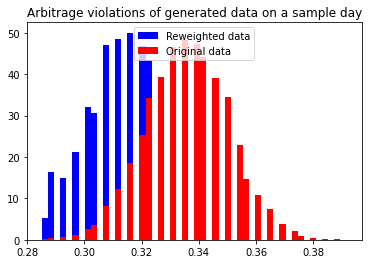

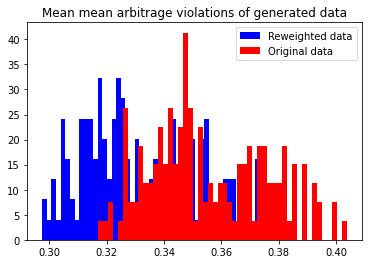

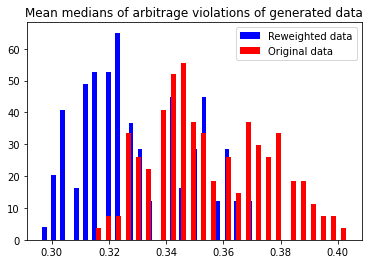

(array([[0.2889734 , 0.29277566, 0.29277566, ..., 0.40304184, 0.40304184,
         0.4068441 ],
        [0.2851711 , 0.2851711 , 0.2889734 , ..., 0.3878327 , 0.3878327 ,
         0.39163497],
        [0.27376425, 0.27756655, 0.27756655, ..., 0.38403043, 0.3878327 ,
         0.39163497],
        ...,
        [0.26996198, 0.26996198, 0.28136882, ..., 0.39163497, 0.39543727,
         0.41444868],
        [0.28136882, 0.28136882, 0.2851711 , ..., 0.38022813, 0.38403043,
         0.38403043],
        [0.27376425, 0.28136882, 0.28136882, ..., 0.37642586, 0.38022813,
         0.38403043]], dtype=float32),
 array([[1.1442986e-02, 7.8236321e-03, 7.8236321e-03, ..., 1.2723585e-07,
         1.2723585e-07, 8.6992017e-08],
        [5.6721279e-03, 5.6721279e-03, 3.8780577e-03, ..., 1.9733683e-07,
         1.9733683e-07, 1.3492053e-07],
        [1.2708091e-02, 8.6885756e-03, 8.6885756e-03, ..., 2.0667187e-07,
         1.4130242e-07, 9.6609433e-08],
        ...,
        [2.7083281e-02, 2.7083281e-02, 

In [12]:
arb_penalties_np = arb_penalties_tensor.cpu().numpy().T
df_arb = pd.DataFrame(arb_penalties_np, index=dates_t[-n_test:], columns=[str(i) for i in range(arb_penalties_np.shape[1])])

from reweighting import reweighting_stats
stats = reweighting_stats(df_arb.to_numpy(), 100)

stats

In [14]:
time_series_surfaces

[tensor([[[ 71.0874],
          [ 97.5076],
          [112.6830],
          ...,
          [ 58.4112],
          [ 59.4679],
          [ 56.1708]],
 
         [[ 73.7295],
          [103.1258],
          [105.5679],
          ...,
          [ 63.0069],
          [ 63.9895],
          [ 60.9198]],
 
         [[ 74.7602],
          [ 84.6341],
          [ 91.8171],
          ...,
          [ 62.1983],
          [ 61.2953],
          [ 61.5503]],
 
         ...,
 
         [[ 77.9694],
          [111.7741],
          [109.6729],
          ...,
          [ 68.5197],
          [ 64.4564],
          [ 58.0448]],
 
         [[ 74.4336],
          [110.9430],
          [102.6983],
          ...,
          [ 71.4149],
          [ 66.9422],
          [ 69.3410]],
 
         [[ 67.7543],
          [ 89.3140],
          [ 94.5082],
          ...,
          [ 65.9941],
          [ 70.6176],
          [ 71.7994]]]),
 tensor([[[ 74.8017],
          [ 95.5451],
          [ 99.9937],
          ...,
   

In [18]:
time_series_surfaces_tensor = torch.stack(time_series_surfaces, dim=0)  # [B, n_test, 144]

time_series_surfaces_tensor = time_series_surfaces_tensor.transpose(0, 1)  # [n_test, B, 144]

weights_tensor = torch.tensor(stats[1], device=device, dtype=torch.float)
surfaces_tensor = time_series_surfaces_tensor.squeeze(-1)  # from [116, 10000, 144, 1] to [116, 10000, 144]
weights_tensor = weights_tensor.unsqueeze(-1)  # [116, 10000, 1]
final_surface = (weights_tensor * surfaces_tensor).sum(dim=1)  # [116, 144]
final_surface.shape
final_surface = final_surface.view(154, 16, 9)


In [19]:
final_surface_np = final_surface.view(n_test, -1).cpu().numpy()

index_dates = dates_t[-n_test:]
df_final_surface = pd.DataFrame(final_surface_np, index=index_dates, columns=multi_index)

df_final_surface

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Ticker                                                                          
2024-05-29                  74.147575          102.201698          104.420456   
2024-05-30                  72.205956          100.918655          102.873520   
2024-05-31                  63.486320           87.916916           91.436165   
2024-06-03                  65.350845           92.669563           93.761162   
2024-06-04                  71.280075           95.780663           97.192375   
...                               ...                 ...                 ...   
2025-01-06                  78.853630          100.345848          102.268883   
2025-01-07                  85.985420          107.037354          106.411766   
2025-01-08                  81.516357          105.647110          106.103401   
2025-01-09                  79.020851          103.875923          106.391258   
2025-01-10                  69.545662           96.153954           99.611397   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Ticker                                                                          
2024-05-29                 106.843643          103.542755          102.119148   
2024-05-30                 102.343147          101.188393           98.071678   
2024-05-31                  93.438286           95.471786           93.758018   
2024-06-03                  98.366905           97.680969           95.916862   
2024-06-04                  99.591301           98.783340           95.737053   
...                               ...                 ...                 ...   
2025-01-06                 104.938332          106.087059          104.734055   
2025-01-07                 106.015892          107.596451          107.475990   
2025-01-08                 107.158501          105.441521          104.205063   
2025-01-09                 108.183273          109.420128          107.959763   
2025-01-10                 102.126556          104.084442          103.104759   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Ticker                                                                          
2024-05-29                  99.918724           97.340691           96.005920   
2024-05-30                  96.743011           94.795456           93.414391   
2024-05-31                  91.293785           89.961998           88.604965   
2024-06-03                  94.438675           93.642891           91.202354   
2024-06-04                  93.292671           91.139008           89.465523   
...                               ...                 ...                 ...   
2025-01-06                 101.863869          100.941307          100.561172   
2025-01-07                 102.087631          101.462242          102.514381   
2025-01-08                 104.176048          102.683075           98.138733   
2025-01-09                 106.098473          105.635620          105.981071   
2025-01-10                 100.838837          101.448952          100.186615   

MATRUITY (EXPIRY)                  3M  ...                  25Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA259 ICPL Curncy   
Ticker                                 ...                        
2024-05-29                  80.128654  ...            63.392757   
2024-05-30       

In [20]:
final_surface_np = final_surface.view(n_test, -1).cpu().numpy()

index_dates = dates_t[-n_test:]
df_final_surface = pd.DataFrame(final_surface_np, index=index_dates, columns=multi_index)

df_final_surface

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Ticker                                                                          
2024-05-29                  74.147575          102.201698          104.420456   
2024-05-30                  72.205956          100.918655          102.873520   
2024-05-31                  63.486320           87.916916           91.436165   
2024-06-03                  65.350845           92.669563           93.761162   
2024-06-04                  71.280075           95.780663           97.192375   
...                               ...                 ...                 ...   
2025-01-06                  78.853630          100.345848          102.268883   
2025-01-07                  85.985420          107.037354          106.411766   
2025-01-08                  81.516357          105.647110          106.103401   
2025-01-09                  79.020851          103.875923          106.391258   
2025-01-10                  69.545662           96.153954           99.611397   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Ticker                                                                          
2024-05-29                 106.843643          103.542755          102.119148   
2024-05-30                 102.343147          101.188393           98.071678   
2024-05-31                  93.438286           95.471786           93.758018   
2024-06-03                  98.366905           97.680969           95.916862   
2024-06-04                  99.591301           98.783340           95.737053   
...                               ...                 ...                 ...   
2025-01-06                 104.938332          106.087059          104.734055   
2025-01-07                 106.015892          107.596451          107.475990   
2025-01-08                 107.158501          105.441521          104.205063   
2025-01-09                 108.183273          109.420128          107.959763   
2025-01-10                 102.126556          104.084442          103.104759   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Ticker                                                                          
2024-05-29                  99.918724           97.340691           96.005920   
2024-05-30                  96.743011           94.795456           93.414391   
2024-05-31                  91.293785           89.961998           88.604965   
2024-06-03                  94.438675           93.642891           91.202354   
2024-06-04                  93.292671           91.139008           89.465523   
...                               ...                 ...                 ...   
2025-01-06                 101.863869          100.941307          100.561172   
2025-01-07                 102.087631          101.462242          102.514381   
2025-01-08                 104.176048          102.683075           98.138733   
2025-01-09                 106.098473          105.635620          105.981071   
2025-01-10                 100.838837          101.448952          100.186615   

MATRUITY (EXPIRY)                  3M  ...                  25Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA259 ICPL Curncy   
Ticker                                 ...                        
2024-05-29                  80.128654  ...            63.392757   
2024-05-30       

In [21]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 10000

# collecting test surfaces from the generator

time_series_surfaces = []

print(f'Model: {data_model}')

with torch.no_grad():
    for l in range(B):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])
        surface_past_test = condition_test[:,:,3:]

        #simulated implied vol surfaces as vectors
        if data_model == 'normal':
            fake_surface = fake[:,:,1:] + surface_past_test
        elif data_model == 'log':
            fake_surface = torch.exp(fake[:,:,1:] + surface_past_test)
    
        time_series_surfaces.append(fake_surface[:, 0, 0])

Model: log


In [22]:
Y1_M1_pred = pd.DataFrame(time_series_surfaces)
Y1_M1_pred = Y1_M1_pred.applymap(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

In [23]:
percentile_2_5 = Y1_M1_pred.quantile(0.025).shift(1)
percentile_97_5 = Y1_M1_pred.quantile(0.975).shift(1)
reweighted = df_final_surface.loc[:, ('1M', '1Y', 'USSNAA1 ICPL Curncy')].shift(1).tolist()

# Create a new DataFrame to store the timeseries of percentiles
percentile_df = pd.DataFrame({
    '2.5 percentile': percentile_2_5,
    '97.5 percentile': percentile_97_5,
    'reweighted': reweighted
})

In [24]:
percentile_df.max()

2.5 percentile     132.718411
97.5 percentile    206.701277
reweighted         148.351944
dtype: float64

In [25]:
percentile_df.index = pd.to_datetime(dates_t[-n_test:])

In [26]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted
Ticker,,,
2024-05-29,NaN,NaN,NaN
2024-05-30,66.847716,85.133244,74.147575
2024-05-31,66.177316,79.614608,72.205956
2024-06-03,58.463549,73.865743,63.486320
2024-06-04,57.839228,80.392097,65.350845
...,...,...,...
2025-01-06,68.287005,90.309530,75.872986
2025-01-07,71.015790,90.983938,78.853630
2025-01-08,79.238836,94.461897,85.985420


In [27]:
true_surfaces = pd.read_excel(SURFACE_PATH, header=[0,1,2], index_col=0).sort_index()

In [28]:
true_surfaces = true_surfaces.loc[dates_t[-n_test]:]

In [29]:
dates_t[-n_test:].shape

(154,)

In [30]:
dates_t

DatetimeIndex(['2021-10-21', '2021-10-22', '2021-10-25', '2021-10-26',
               '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01',
               '2021-11-02', '2021-11-03',
               ...
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-02',
               '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-09', '2025-01-10'],
              dtype='datetime64[ns]', name='Ticker', length=769, freq=None)

In [31]:
# get first column of the true surfaces
true_surfaces.iloc[:, 0]

2024-05-29    72.2
2024-05-30    69.5
2024-05-31    69.4
2024-06-03    72.1
2024-06-04    77.7
              ... 
2025-01-06    78.5
2025-01-07    83.5
2025-01-08    80.9
2025-01-09    79.9
2025-01-10    72.2
Name: (1M, 1Y, USSNAA1 ICPL Curncy), Length: 154, dtype: float64

In [32]:
percentile_df['true'] = true_surfaces.iloc[:, 0]

In [33]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted,true
Ticker,,,,
2024-05-29,NaN,NaN,NaN,72.2
2024-05-30,66.847716,85.133244,74.147575,69.5
2024-05-31,66.177316,79.614608,72.205956,69.4
2024-06-03,58.463549,73.865743,63.486320,72.1
2024-06-04,57.839228,80.392097,65.350845,77.7
...,...,...,...,...
2025-01-06,68.287005,90.309530,75.872986,78.5
2025-01-07,71.015790,90.983938,78.853630,83.5
2025-01-08,79.238836,94.461897,85.985420,80.9


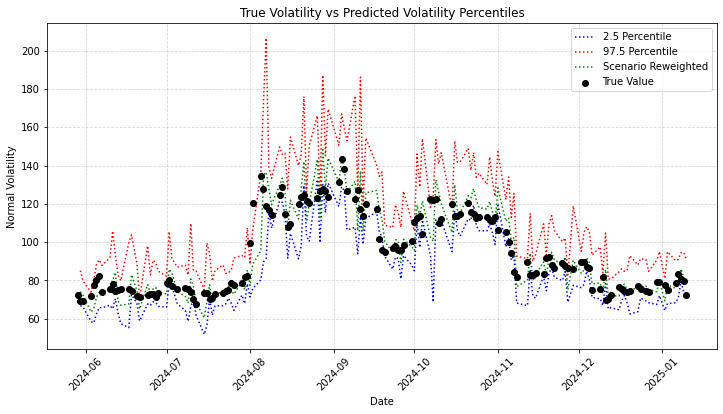

In [34]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(percentile_df.index, percentile_df["2.5 percentile"], linestyle="dotted", color="blue", label="2.5 Percentile")
plt.plot(percentile_df.index, percentile_df["97.5 percentile"], linestyle="dotted", color="red", label="97.5 Percentile")
plt.plot(percentile_df.index, percentile_df["reweighted"], linestyle="dotted", color="green", label="Scenario Reweighted")
plt.scatter(percentile_df.index, percentile_df["true"], color="black", label="True Value", zorder=3)

# Labels and Legend
plt.xlabel("Date")
plt.ylabel("Normal Volatility")
plt.title("True Volatility vs Predicted Volatility Percentiles")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

---------------------------------------------
# ONLY STUFF ABOVE HERE SO FAR 
## Below is future testing logic
---------------------------------------------